In [4]:
import argparse
import gym
from gym import wrappers
import os.path as osp
import random
import numpy as np
import itertools
import tensorflow as tf
import tensorflow.contrib.layers as layers
import time 

import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
import plotting

import dqn
from dqn_utils import *
#from atari_wrappers import *
#from environments.arm_env.arm_env import ArmEnv
from arm_env_dqn_lift_cube import ArmEnvDQN_2

In [5]:

def arm_model(img_in, num_actions, scope, reuse=False):
    # as described in https://storage.googleapis.com/deepmind-data/assets/papers/DeepMindNature14236Paper.pdf
    with tf.variable_scope(scope, reuse=reuse):
        out = img_in
        with tf.variable_scope("convnet"):
            # original architecture
            out = layers.convolution2d(out, num_outputs=32, kernel_size=8, stride=4, activation_fn=tf.nn.relu)
            out = layers.convolution2d(out, num_outputs=64, kernel_size=4, stride=2, activation_fn=tf.nn.relu)
            out = layers.convolution2d(out, num_outputs=64, kernel_size=3, stride=1, activation_fn=tf.nn.relu)
        out = layers.flatten(out)
        with tf.variable_scope("action_value"):
            out = layers.fully_connected(out, num_outputs=256,         activation_fn=tf.nn.relu)
            out = layers.fully_connected(out, num_outputs=num_actions, activation_fn=None)

        return out


def arm_learn(env, session, num_timesteps):
    # This is just a rough estimate
    num_iterations = float(num_timesteps) / 4.0

    lr_multiplier = 1.0
    lr_schedule = PiecewiseSchedule([
                                         (0,                   1e-4 * lr_multiplier),
                                         (num_iterations / 10, 1e-4 * lr_multiplier),
                                         (num_iterations / 2,  5e-5 * lr_multiplier),
                                    ],
                                    outside_value=5e-5 * lr_multiplier)
    optimizer = dqn.OptimizerSpec(
        constructor=tf.train.AdamOptimizer,
        kwargs=dict(epsilon=1e-4),
        lr_schedule=lr_schedule
    )

    def stopping_criterion(env, t):
        # notice that here t is the number of steps of the wrapped env,
        # which is different from the number of steps in the underlying env
        return t >= num_timesteps

    exploration_schedule = PiecewiseSchedule(
        [
            (0, 1.0),
            (8e3, 0.3),
            (num_iterations, 0.01),
        ], outside_value=0.01
    )

    dqn.learn(
        env,
        q_func=arm_model,
        optimizer_spec=optimizer,
        session=session,
        exploration=exploration_schedule,
        stopping_criterion=stopping_criterion,
        replay_buffer_size=1000000,
        batch_size=32,
        gamma=0.99,
        learning_starts=5000,
        learning_freq=1,
        frame_history_len=1,
        target_update_freq=200,
        grad_norm_clipping=10
    )
    
    ep_rew = env.get_episode_rewards()
    ep_len = env.get_episode_lengths()
    env.close()
    return ep_rew, ep_len

def get_available_gpus():
    from tensorflow.python.client import device_lib
    local_device_protos = device_lib.list_local_devices()
    return [x.physical_device_desc for x in local_device_protos if x.device_type == 'GPU']

def set_global_seeds(i):
    try:
        import tensorflow as tf
    except ImportError:
        pass
    else:
        tf.set_random_seed(i) 
    np.random.seed(i)
    random.seed(i)

def get_session():
    tf.reset_default_graph()
#     tf_config = tf.ConfigProto(
#         inter_op_parallelism_threads=1,
#         intra_op_parallelism_threads=1)
    session = tf.Session(config=tf.ConfigProto(log_device_placement=True))
    print("AVAILABLE GPUS: ", get_available_gpus())
    session = tf.Session()
    return session



AVAILABLE GPUS:  []
Timestep 5500
mean reward (50 episodes) -383.320000
mean length (50 episodes) 94.120000
max_episode_reward (50 episodes) 37.000000
min_episode_length (50 episodes) 23.000000
min_episode_reward (50 episodes) -530.000000
max_episode_length (50 episodes) 100.000000
best mean reward -383.320000
episodes 57
exploration 0.518750
learning_rate 0.000100


Timestep 6000
mean reward (50 episodes) -362.480000
mean length (50 episodes) 93.880000
max_episode_reward (50 episodes) 37.000000
min_episode_length (50 episodes) 23.000000
min_episode_reward (50 episodes) -530.000000
max_episode_length (50 episodes) 100.000000
best mean reward -362.480000
episodes 63
exploration 0.475000
learning_rate 0.000100


Timestep 6500
mean reward (50 episodes) -347.080000
mean length (50 episodes) 93.880000
max_episode_reward (50 episodes) 37.000000
min_episode_length (50 episodes) 23.000000
min_episode_reward (50 episodes) -530.000000
max_episode_length (50 episodes) 100.000000
best mean reward 

Timestep 17500
mean reward (50 episodes) -25.820000
mean length (50 episodes) 56.020000
max_episode_reward (50 episodes) 92.000000
min_episode_length (50 episodes) 8.000000
min_episode_reward (50 episodes) -210.000000
max_episode_length (50 episodes) 100.000000
best mean reward -21.640000
episodes 229
exploration 0.270054
learning_rate 0.000091


Timestep 18000
mean reward (50 episodes) -28.460000
mean length (50 episodes) 56.660000
max_episode_reward (50 episodes) 81.000000
min_episode_length (50 episodes) 9.000000
min_episode_reward (50 episodes) -210.000000
max_episode_length (50 episodes) 100.000000
best mean reward -19.920000
episodes 239
exploration 0.268478
learning_rate 0.000090


Timestep 18500
mean reward (50 episodes) -45.500000
mean length (50 episodes) 62.100000
max_episode_reward (50 episodes) 78.000000
min_episode_length (50 episodes) 12.000000
min_episode_reward (50 episodes) -240.000000
max_episode_length (50 episodes) 100.000000
best mean reward -19.920000
episodes 24

Timestep 29500
mean reward (50 episodes) 34.080000
mean length (50 episodes) 32.920000
max_episode_reward (50 episodes) 93.000000
min_episode_length (50 episodes) 6.000000
min_episode_reward (50 episodes) -190.000000
max_episode_length (50 episodes) 100.000000
best mean reward 46.300000
episodes 546
exploration 0.232228
learning_rate 0.000076


Timestep 30000
mean reward (50 episodes) 31.560000
mean length (50 episodes) 33.240000
max_episode_reward (50 episodes) 92.000000
min_episode_length (50 episodes) 6.000000
min_episode_reward (50 episodes) -190.000000
max_episode_length (50 episodes) 100.000000
best mean reward 46.300000
episodes 559
exploration 0.230652
learning_rate 0.000075


Timestep 30500
mean reward (50 episodes) 25.000000
mean length (50 episodes) 35.400000
max_episode_reward (50 episodes) 92.000000
min_episode_length (50 episodes) 7.000000
min_episode_reward (50 episodes) -180.000000
max_episode_length (50 episodes) 100.000000
best mean reward 46.300000
episodes 573
explo

Timestep 41500
mean reward (50 episodes) -12.980000
mean length (50 episodes) 51.780000
max_episode_reward (50 episodes) 93.000000
min_episode_length (50 episodes) 7.000000
min_episode_reward (50 episodes) -210.000000
max_episode_length (50 episodes) 100.000000
best mean reward 56.340000
episodes 869
exploration 0.194402
learning_rate 0.000061


Timestep 42000
mean reward (50 episodes) -0.480000
mean length (50 episodes) 47.280000
max_episode_reward (50 episodes) 94.000000
min_episode_length (50 episodes) 6.000000
min_episode_reward (50 episodes) -210.000000
max_episode_length (50 episodes) 100.000000
best mean reward 56.340000
episodes 883
exploration 0.192826
learning_rate 0.000060


Timestep 42500
mean reward (50 episodes) -4.560000
mean length (50 episodes) 47.760000
max_episode_reward (50 episodes) 94.000000
min_episode_length (50 episodes) 6.000000
min_episode_reward (50 episodes) -210.000000
max_episode_length (50 episodes) 100.000000
best mean reward 56.340000
episodes 890
expl

Timestep 53500
mean reward (50 episodes) 10.560000
mean length (50 episodes) 42.840000
max_episode_reward (50 episodes) 93.000000
min_episode_length (50 episodes) 7.000000
min_episode_reward (50 episodes) -180.000000
max_episode_length (50 episodes) 100.000000
best mean reward 56.340000
episodes 1097
exploration 0.156576
learning_rate 0.000050


Timestep 54000
mean reward (50 episodes) 1.900000
mean length (50 episodes) 45.700000
max_episode_reward (50 episodes) 93.000000
min_episode_length (50 episodes) 7.000000
min_episode_reward (50 episodes) -180.000000
max_episode_length (50 episodes) 100.000000
best mean reward 56.340000
episodes 1108
exploration 0.155000
learning_rate 0.000050


Timestep 54500
mean reward (50 episodes) 0.840000
mean length (50 episodes) 46.560000
max_episode_reward (50 episodes) 93.000000
min_episode_length (50 episodes) 7.000000
min_episode_reward (50 episodes) -180.000000
max_episode_length (50 episodes) 100.000000
best mean reward 56.340000
episodes 1117
expl

Timestep 65500
mean reward (50 episodes) 21.760000
mean length (50 episodes) 42.640000
max_episode_reward (50 episodes) 93.000000
min_episode_length (50 episodes) 7.000000
min_episode_reward (50 episodes) -160.000000
max_episode_length (50 episodes) 100.000000
best mean reward 56.880000
episodes 1398
exploration 0.118750
learning_rate 0.000050


Timestep 66000
mean reward (50 episodes) 24.340000
mean length (50 episodes) 41.660000
max_episode_reward (50 episodes) 93.000000
min_episode_length (50 episodes) 7.000000
min_episode_reward (50 episodes) -160.000000
max_episode_length (50 episodes) 100.000000
best mean reward 56.880000
episodes 1408
exploration 0.117174
learning_rate 0.000050


Timestep 66500
mean reward (50 episodes) 26.980000
mean length (50 episodes) 40.220000
max_episode_reward (50 episodes) 93.000000
min_episode_length (50 episodes) 7.000000
min_episode_reward (50 episodes) -160.000000
max_episode_length (50 episodes) 100.000000
best mean reward 56.880000
episodes 1424
ex

Timestep 77500
mean reward (50 episodes) 7.240000
mean length (50 episodes) 46.960000
max_episode_reward (50 episodes) 93.000000
min_episode_length (50 episodes) 7.000000
min_episode_reward (50 episodes) -180.000000
max_episode_length (50 episodes) 100.000000
best mean reward 63.600000
episodes 1711
exploration 0.080924
learning_rate 0.000050


Timestep 78000
mean reward (50 episodes) 0.140000
mean length (50 episodes) 50.060000
max_episode_reward (50 episodes) 93.000000
min_episode_length (50 episodes) 7.000000
min_episode_reward (50 episodes) -180.000000
max_episode_length (50 episodes) 100.000000
best mean reward 63.600000
episodes 1720
exploration 0.079348
learning_rate 0.000050


Timestep 78500
mean reward (50 episodes) -1.580000
mean length (50 episodes) 51.180000
max_episode_reward (50 episodes) 93.000000
min_episode_length (50 episodes) 7.000000
min_episode_reward (50 episodes) -180.000000
max_episode_length (50 episodes) 100.000000
best mean reward 63.600000
episodes 1731
expl

Timestep 89500
mean reward (50 episodes) -16.240000
mean length (50 episodes) 56.240000
max_episode_reward (50 episodes) 93.000000
min_episode_length (50 episodes) 7.000000
min_episode_reward (50 episodes) -378.000000
max_episode_length (50 episodes) 100.000000
best mean reward 63.600000
episodes 1974
exploration 0.043098
learning_rate 0.000050


Timestep 90000
mean reward (50 episodes) 3.100000
mean length (50 episodes) 48.100000
max_episode_reward (50 episodes) 93.000000
min_episode_length (50 episodes) 7.000000
min_episode_reward (50 episodes) -140.000000
max_episode_length (50 episodes) 100.000000
best mean reward 63.600000
episodes 1989
exploration 0.041522
learning_rate 0.000050


Timestep 90500
mean reward (50 episodes) 1.820000
mean length (50 episodes) 49.580000
max_episode_reward (50 episodes) 93.000000
min_episode_length (50 episodes) 7.000000
min_episode_reward (50 episodes) -140.000000
max_episode_length (50 episodes) 100.000000
best mean reward 63.600000
episodes 2000
exp

Timestep 101500
mean reward (50 episodes) 42.160000
mean length (50 episodes) 31.240000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) -110.000000
max_episode_length (50 episodes) 100.000000
best mean reward 63.600000
episodes 2327
exploration 0.010000
learning_rate 0.000050


Timestep 102000
mean reward (50 episodes) 29.540000
mean length (50 episodes) 36.460000
max_episode_reward (50 episodes) 93.000000
min_episode_length (50 episodes) 6.000000
min_episode_reward (50 episodes) -110.000000
max_episode_length (50 episodes) 100.000000
best mean reward 63.600000
episodes 2342
exploration 0.010000
learning_rate 0.000050


Timestep 102500
mean reward (50 episodes) 30.840000
mean length (50 episodes) 34.360000
max_episode_reward (50 episodes) 93.000000
min_episode_length (50 episodes) 6.000000
min_episode_reward (50 episodes) -110.000000
max_episode_length (50 episodes) 100.000000
best mean reward 63.600000
episodes 2360

Timestep 113500
mean reward (50 episodes) 49.640000
mean length (50 episodes) 25.760000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) -110.000000
max_episode_length (50 episodes) 100.000000
best mean reward 71.260000
episodes 2767
exploration 0.010000
learning_rate 0.000050


Timestep 114000
mean reward (50 episodes) 41.220000
mean length (50 episodes) 28.780000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) -110.000000
max_episode_length (50 episodes) 100.000000
best mean reward 71.260000
episodes 2782
exploration 0.010000
learning_rate 0.000050


Timestep 114500
mean reward (50 episodes) 39.200000
mean length (50 episodes) 30.000000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) -110.000000
max_episode_length (50 episodes) 100.000000
best mean reward 71.260000
episodes 2802

Timestep 125500
mean reward (50 episodes) 56.440000
mean length (50 episodes) 24.160000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) -120.000000
max_episode_length (50 episodes) 100.000000
best mean reward 76.220000
episodes 3260
exploration 0.010000
learning_rate 0.000050


Timestep 126000
mean reward (50 episodes) 54.740000
mean length (50 episodes) 24.260000
max_episode_reward (50 episodes) 93.000000
min_episode_length (50 episodes) 7.000000
min_episode_reward (50 episodes) -120.000000
max_episode_length (50 episodes) 100.000000
best mean reward 76.220000
episodes 3285
exploration 0.010000
learning_rate 0.000050


Timestep 126500
mean reward (50 episodes) 62.880000
mean length (50 episodes) 17.920000
max_episode_reward (50 episodes) 93.000000
min_episode_length (50 episodes) 7.000000
min_episode_reward (50 episodes) -120.000000
max_episode_length (50 episodes) 100.000000
best mean reward 76.220000
episodes 3312

Timestep 137500
mean reward (50 episodes) 55.460000
mean length (50 episodes) 24.140000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) -120.000000
max_episode_length (50 episodes) 100.000000
best mean reward 77.180000
episodes 3837
exploration 0.010000
learning_rate 0.000050


Timestep 138000
mean reward (50 episodes) 55.740000
mean length (50 episodes) 22.860000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) -110.000000
max_episode_length (50 episodes) 100.000000
best mean reward 77.180000
episodes 3859
exploration 0.010000
learning_rate 0.000050


Timestep 138500
mean reward (50 episodes) 58.000000
mean length (50 episodes) 21.200000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) -110.000000
max_episode_length (50 episodes) 100.000000
best mean reward 77.180000
episodes 3885

Timestep 149500
mean reward (50 episodes) 63.360000
mean length (50 episodes) 20.840000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) -110.000000
max_episode_length (50 episodes) 100.000000
best mean reward 77.180000
episodes 4517
exploration 0.010000
learning_rate 0.000050


Timestep 150000
mean reward (50 episodes) 54.960000
mean length (50 episodes) 25.840000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) -110.000000
max_episode_length (50 episodes) 100.000000
best mean reward 77.180000
episodes 4534
exploration 0.010000
learning_rate 0.000050


Timestep 150500
mean reward (50 episodes) 82.000000
mean length (50 episodes) 11.200000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) -100.000000
max_episode_length (50 episodes) 100.000000
best mean reward 82.000000
episodes 4581

Timestep 161500
mean reward (50 episodes) 71.160000
mean length (50 episodes) 15.440000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) -110.000000
max_episode_length (50 episodes) 100.000000
best mean reward 86.500000
episodes 5191
exploration 0.010000
learning_rate 0.000050


Timestep 162000
mean reward (50 episodes) 76.220000
mean length (50 episodes) 12.780000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) -100.000000
max_episode_length (50 episodes) 100.000000
best mean reward 86.500000
episodes 5231
exploration 0.010000
learning_rate 0.000050


Timestep 162500
mean reward (50 episodes) 76.420000
mean length (50 episodes) 12.380000
max_episode_reward (50 episodes) 93.000000
min_episode_length (50 episodes) 7.000000
min_episode_reward (50 episodes) -100.000000
max_episode_length (50 episodes) 100.000000
best mean reward 86.500000
episodes 5269

Timestep 173500
mean reward (50 episodes) 70.140000
mean length (50 episodes) 17.060000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) -110.000000
max_episode_length (50 episodes) 100.000000
best mean reward 86.500000
episodes 5902
exploration 0.010000
learning_rate 0.000050


Timestep 174000
mean reward (50 episodes) 74.860000
mean length (50 episodes) 13.940000
max_episode_reward (50 episodes) 93.000000
min_episode_length (50 episodes) 7.000000
min_episode_reward (50 episodes) -120.000000
max_episode_length (50 episodes) 100.000000
best mean reward 86.500000
episodes 5944
exploration 0.010000
learning_rate 0.000050


Timestep 174500
mean reward (50 episodes) 74.740000
mean length (50 episodes) 13.460000
max_episode_reward (50 episodes) 94.000000
min_episode_length (50 episodes) 6.000000
min_episode_reward (50 episodes) -110.000000
max_episode_length (50 episodes) 100.000000
best mean reward 86.500000
episodes 5974

Timestep 185500
mean reward (50 episodes) 71.200000
mean length (50 episodes) 15.000000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) -110.000000
max_episode_length (50 episodes) 100.000000
best mean reward 86.500000
episodes 6744
exploration 0.010000
learning_rate 0.000050


Timestep 186000
mean reward (50 episodes) 66.640000
mean length (50 episodes) 18.560000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) -110.000000
max_episode_length (50 episodes) 100.000000
best mean reward 86.500000
episodes 6763
exploration 0.010000
learning_rate 0.000050


Timestep 186500
mean reward (50 episodes) 56.540000
mean length (50 episodes) 23.060000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) -110.000000
max_episode_length (50 episodes) 100.000000
best mean reward 86.500000
episodes 6784

Timestep 197500
mean reward (50 episodes) 78.680000
mean length (50 episodes) 12.320000
max_episode_reward (50 episodes) 93.000000
min_episode_length (50 episodes) 6.000000
min_episode_reward (50 episodes) -100.000000
max_episode_length (50 episodes) 100.000000
best mean reward 86.500000
episodes 7617
exploration 0.010000
learning_rate 0.000050


Timestep 198000
mean reward (50 episodes) 76.260000
mean length (50 episodes) 12.340000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) -110.000000
max_episode_length (50 episodes) 100.000000
best mean reward 86.500000
episodes 7661
exploration 0.010000
learning_rate 0.000050


Timestep 198500
mean reward (50 episodes) 76.620000
mean length (50 episodes) 12.380000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) -100.000000
max_episode_length (50 episodes) 100.000000
best mean reward 86.500000
episodes 7687

Timestep 209500
mean reward (50 episodes) 79.500000
mean length (50 episodes) 12.300000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) -110.000000
max_episode_length (50 episodes) 100.000000
best mean reward 86.560000
episodes 8612
exploration 0.010000
learning_rate 0.000050


Timestep 210000
mean reward (50 episodes) 66.560000
mean length (50 episodes) 18.640000
max_episode_reward (50 episodes) 93.000000
min_episode_length (50 episodes) 7.000000
min_episode_reward (50 episodes) -110.000000
max_episode_length (50 episodes) 100.000000
best mean reward 86.560000
episodes 8636
exploration 0.010000
learning_rate 0.000050


Timestep 210500
mean reward (50 episodes) 71.900000
mean length (50 episodes) 13.900000
max_episode_reward (50 episodes) 93.000000
min_episode_length (50 episodes) 6.000000
min_episode_reward (50 episodes) -100.000000
max_episode_length (50 episodes) 100.000000
best mean reward 86.560000
episodes 8674

Timestep 221500
mean reward (50 episodes) 82.280000
mean length (50 episodes) 11.720000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) 11.000000
max_episode_length (50 episodes) 79.000000
best mean reward 87.100000
episodes 9701
exploration 0.010000
learning_rate 0.000050


Timestep 222000
mean reward (50 episodes) 85.160000
mean length (50 episodes) 8.840000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) 58.000000
max_episode_length (50 episodes) 25.000000
best mean reward 87.100000
episodes 9756
exploration 0.010000
learning_rate 0.000050


Timestep 222500
mean reward (50 episodes) 82.660000
mean length (50 episodes) 9.940000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) 26.000000
max_episode_length (50 episodes) 64.000000
best mean reward 87.100000
episodes 9805
exploratio

Timestep 233500
mean reward (50 episodes) 77.200000
mean length (50 episodes) 13.800000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) -130.000000
max_episode_length (50 episodes) 100.000000
best mean reward 88.800000
episodes 10857
exploration 0.010000
learning_rate 0.000050


Timestep 234000
mean reward (50 episodes) 74.520000
mean length (50 episodes) 15.680000
max_episode_reward (50 episodes) 93.000000
min_episode_length (50 episodes) 6.000000
min_episode_reward (50 episodes) -130.000000
max_episode_length (50 episodes) 100.000000
best mean reward 88.800000
episodes 10891
exploration 0.010000
learning_rate 0.000050


Timestep 234500
mean reward (50 episodes) 78.080000
mean length (50 episodes) 10.920000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) -100.000000
max_episode_length (50 episodes) 100.000000
best mean reward 88.800000
episodes 10

Timestep 245500
mean reward (50 episodes) 83.740000
mean length (50 episodes) 8.460000
max_episode_reward (50 episodes) 93.000000
min_episode_length (50 episodes) 6.000000
min_episode_reward (50 episodes) 49.000000
max_episode_length (50 episodes) 15.000000
best mean reward 88.800000
episodes 12072
exploration 0.010000
learning_rate 0.000050


Timestep 246000
mean reward (50 episodes) 79.400000
mean length (50 episodes) 12.000000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) -100.000000
max_episode_length (50 episodes) 100.000000
best mean reward 88.800000
episodes 12111
exploration 0.010000
learning_rate 0.000050


Timestep 246500
mean reward (50 episodes) 73.080000
mean length (50 episodes) 15.120000
max_episode_reward (50 episodes) 93.000000
min_episode_length (50 episodes) 6.000000
min_episode_reward (50 episodes) -100.000000
max_episode_length (50 episodes) 100.000000
best mean reward 88.800000
episodes 12141


Timestep 257500
mean reward (50 episodes) 84.280000
mean length (50 episodes) 8.720000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) 60.000000
max_episode_length (50 episodes) 18.000000
best mean reward 88.800000
episodes 13205
exploration 0.010000
learning_rate 0.000050


Timestep 258000
mean reward (50 episodes) 86.440000
mean length (50 episodes) 8.160000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) 60.000000
max_episode_length (50 episodes) 10.000000
best mean reward 88.800000
episodes 13266
exploration 0.010000
learning_rate 0.000050


Timestep 258500
mean reward (50 episodes) 82.760000
mean length (50 episodes) 8.640000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) 60.000000
max_episode_length (50 episodes) 19.000000
best mean reward 88.800000
episodes 13325
explorat

Timestep 269500
mean reward (50 episodes) 82.760000
mean length (50 episodes) 9.840000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) -100.000000
max_episode_length (50 episodes) 100.000000
best mean reward 88.800000
episodes 14562
exploration 0.010000
learning_rate 0.000050


Timestep 270000
mean reward (50 episodes) 86.580000
mean length (50 episodes) 8.420000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) 69.000000
max_episode_length (50 episodes) 15.000000
best mean reward 88.800000
episodes 14621
exploration 0.010000
learning_rate 0.000050


Timestep 270500
mean reward (50 episodes) 84.580000
mean length (50 episodes) 8.020000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) 60.000000
max_episode_length (50 episodes) 10.000000
best mean reward 88.800000
episodes 14682
explo

Timestep 281500
mean reward (50 episodes) 84.900000
mean length (50 episodes) 8.300000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) 60.000000
max_episode_length (50 episodes) 11.000000
best mean reward 88.800000
episodes 15864
exploration 0.010000
learning_rate 0.000050


Timestep 282000
mean reward (50 episodes) 86.840000
mean length (50 episodes) 8.160000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) 71.000000
max_episode_length (50 episodes) 10.000000
best mean reward 88.800000
episodes 15926
exploration 0.010000
learning_rate 0.000050


Timestep 282500
mean reward (50 episodes) 83.160000
mean length (50 episodes) 8.040000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) 49.000000
max_episode_length (50 episodes) 11.000000
best mean reward 88.800000
episodes 15988
explorat

Timestep 293500
mean reward (50 episodes) 84.160000
mean length (50 episodes) 8.440000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) 60.000000
max_episode_length (50 episodes) 17.000000
best mean reward 88.840000
episodes 17168
exploration 0.010000
learning_rate 0.000050


Timestep 294000
mean reward (50 episodes) 87.280000
mean length (50 episodes) 8.120000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) 60.000000
max_episode_length (50 episodes) 14.000000
best mean reward 88.840000
episodes 17229
exploration 0.010000
learning_rate 0.000050


Timestep 294500
mean reward (50 episodes) 82.960000
mean length (50 episodes) 10.040000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) -100.000000
max_episode_length (50 episodes) 100.000000
best mean reward 88.840000
episodes 17278
expl

Timestep 305500
mean reward (50 episodes) 86.460000
mean length (50 episodes) 8.340000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) 70.000000
max_episode_length (50 episodes) 10.000000
best mean reward 88.840000
episodes 18514
exploration 0.010000
learning_rate 0.000050


Timestep 306000
mean reward (50 episodes) 86.860000
mean length (50 episodes) 9.340000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) 28.000000
max_episode_length (50 episodes) 62.000000
best mean reward 88.840000
episodes 18567
exploration 0.010000
learning_rate 0.000050


Timestep 306500
mean reward (50 episodes) 86.600000
mean length (50 episodes) 8.200000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) 67.000000
max_episode_length (50 episodes) 13.000000
best mean reward 88.840000
episodes 18628
explorat

Timestep 317500
mean reward (50 episodes) 85.440000
mean length (50 episodes) 8.960000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) 40.000000
max_episode_length (50 episodes) 33.000000
best mean reward 88.840000
episodes 19890
exploration 0.010000
learning_rate 0.000050


Timestep 318000
mean reward (50 episodes) 84.200000
mean length (50 episodes) 9.400000
max_episode_reward (50 episodes) 93.000000
min_episode_length (50 episodes) 6.000000
min_episode_reward (50 episodes) 38.000000
max_episode_length (50 episodes) 52.000000
best mean reward 88.840000
episodes 19944
exploration 0.010000
learning_rate 0.000050


Timestep 318500
mean reward (50 episodes) 86.820000
mean length (50 episodes) 8.380000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) 71.000000
max_episode_length (50 episodes) 15.000000
best mean reward 88.840000
episodes 20004
explorat

Timestep 329500
mean reward (50 episodes) 86.260000
mean length (50 episodes) 8.140000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) 56.000000
max_episode_length (50 episodes) 14.000000
best mean reward 88.840000
episodes 21333
exploration 0.010000
learning_rate 0.000050


Timestep 330000
mean reward (50 episodes) 86.880000
mean length (50 episodes) 8.520000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) 69.000000
max_episode_length (50 episodes) 15.000000
best mean reward 88.840000
episodes 21392
exploration 0.010000
learning_rate 0.000050


Timestep 330500
mean reward (50 episodes) 86.220000
mean length (50 episodes) 8.380000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) 62.000000
max_episode_length (50 episodes) 11.000000
best mean reward 88.840000
episodes 21452
explorat

Timestep 341500
mean reward (50 episodes) 85.920000
mean length (50 episodes) 8.080000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) 62.000000
max_episode_length (50 episodes) 10.000000
best mean reward 88.860000
episodes 22794
exploration 0.010000
learning_rate 0.000050


Timestep 342000
mean reward (50 episodes) 85.780000
mean length (50 episodes) 8.020000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) 62.000000
max_episode_length (50 episodes) 12.000000
best mean reward 88.860000
episodes 22856
exploration 0.010000
learning_rate 0.000050


Timestep 342500
mean reward (50 episodes) 87.240000
mean length (50 episodes) 8.360000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) 66.000000
max_episode_length (50 episodes) 14.000000
best mean reward 88.860000
episodes 22916
explorat

Timestep 353500
mean reward (50 episodes) 86.840000
mean length (50 episodes) 7.960000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) 62.000000
max_episode_length (50 episodes) 11.000000
best mean reward 88.860000
episodes 24256
exploration 0.010000
learning_rate 0.000050


Timestep 354000
mean reward (50 episodes) 86.220000
mean length (50 episodes) 8.180000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) 57.000000
max_episode_length (50 episodes) 13.000000
best mean reward 88.860000
episodes 24317
exploration 0.010000
learning_rate 0.000050


Timestep 354500
mean reward (50 episodes) 87.220000
mean length (50 episodes) 7.980000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) 62.000000
max_episode_length (50 episodes) 18.000000
best mean reward 88.860000
episodes 24379
explorat

Timestep 365500
mean reward (50 episodes) 86.640000
mean length (50 episodes) 8.560000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) 71.000000
max_episode_length (50 episodes) 18.000000
best mean reward 89.260000
episodes 25710
exploration 0.010000
learning_rate 0.000050


Timestep 366000
mean reward (50 episodes) 85.640000
mean length (50 episodes) 8.160000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) 60.000000
max_episode_length (50 episodes) 11.000000
best mean reward 89.260000
episodes 25772
exploration 0.010000
learning_rate 0.000050


Timestep 366500
mean reward (50 episodes) 87.360000
mean length (50 episodes) 8.040000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) 62.000000
max_episode_length (50 episodes) 11.000000
best mean reward 89.260000
episodes 25834
explorat

Timestep 377500
mean reward (50 episodes) 86.720000
mean length (50 episodes) 8.080000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) 62.000000
max_episode_length (50 episodes) 10.000000
best mean reward 89.260000
episodes 27174
exploration 0.010000
learning_rate 0.000050


Timestep 378000
mean reward (50 episodes) 87.760000
mean length (50 episodes) 8.040000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) 62.000000
max_episode_length (50 episodes) 10.000000
best mean reward 89.260000
episodes 27236
exploration 0.010000
learning_rate 0.000050


Timestep 378500
mean reward (50 episodes) 85.420000
mean length (50 episodes) 8.380000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) 62.000000
max_episode_length (50 episodes) 11.000000
best mean reward 89.260000
episodes 27296
explorat

Timestep 389500
mean reward (50 episodes) 88.780000
mean length (50 episodes) 8.020000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) 73.000000
max_episode_length (50 episodes) 10.000000
best mean reward 89.820000
episodes 28635
exploration 0.010000
learning_rate 0.000050


Timestep 390000
mean reward (50 episodes) 87.040000
mean length (50 episodes) 8.360000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) 61.000000
max_episode_length (50 episodes) 11.000000
best mean reward 89.820000
episodes 28695
exploration 0.010000
learning_rate 0.000050


Timestep 390500
mean reward (50 episodes) 83.860000
mean length (50 episodes) 8.340000
max_episode_reward (50 episodes) 95.000000
min_episode_length (50 episodes) 5.000000
min_episode_reward (50 episodes) 58.000000
max_episode_length (50 episodes) 12.000000
best mean reward 89.820000
episodes 28756
explorat

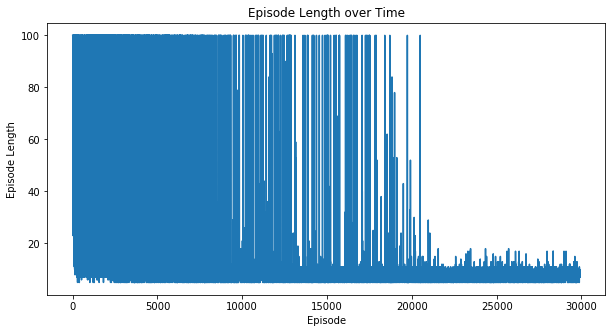

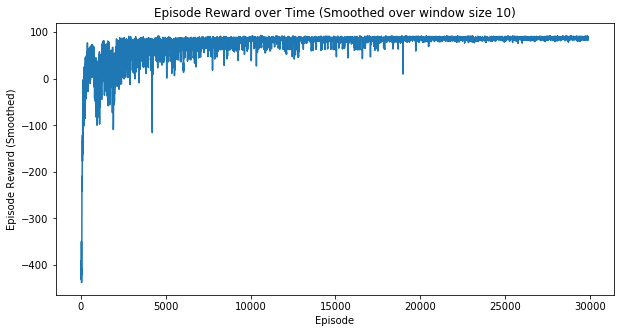

In [6]:
def main():
    # Get Atari games.
    # benchmark = gym.benchmark_spec('Atari40M')
    #
    # # Change the index to select a different game.
    # task = benchmark.tasks[3]
    #
    # # Run training
#     seed = 0  # Use a seed of zero (you may want to randomize the seed!)
#     set_global_seeds(seed)
    # env = get_env(task, seed)
    env = ArmEnvDQN_2(episode_max_length=100,
                 size_x=6,
                 size_y=4,
                 cubes_cnt=4,
                 scaling_coeff=3,
                 action_minus_reward=-1,
                 finish_reward=100,
                 tower_target_size=4)
    session = get_session()

    start = time.time()
    ep_rew, ep_len = arm_learn(env, session, num_timesteps=400000)
    end = time.time()
    print(end - start)
    
    stats = plotting.EpisodeStats(
        episode_lengths=ep_len,
        episode_rewards=ep_rew)
    plotting.plot_episode_stats(stats)

if __name__ == "__main__":
    main()

In [ ]:
def encode_observation(frame):
    img_h, img_w = frame.shape[1], frame.shape[2]
    return frame.transpose(1, 2, 0, 3).reshape(img_h, img_w, -1)

def main():
    env = ArmEnvDQN(episode_max_length=200,
                 size_x=5,
                 size_y=5,
                 cubes_cnt=4,
                 scaling_coeff=3,
                 action_minus_reward=-1,
                 finish_reward=400,
                 tower_target_size=4)
    # print(env.reset())
    session = tf.Session()
    # First let's load meta graph and restore weights
    saver = tf.train.import_meta_graph('option_go_down.meta')
    saver.restore(session, tf.train.latest_checkpoint('./'))
    frame_history_len = 1
    img_h, img_w, img_c = env.observation_space.shape
    input_shape = (img_h, img_w, frame_history_len * img_c)  # size_x, size_y,
    num_actions = env.action_space.n

#     # placeholder for current observation (or state)
#     obs_t_ph = tf.placeholder(tf.uint8, [None] + list(input_shape))
#     # casting to float on GPU ensures lower data transfer times.
#     obs_t_float = tf.cast(obs_t_ph, tf.float32) / 255.0



#     pred_q = q_func(obs_t_float, num_actions, scope="q_func", reuse=False)
#     pred_ac = tf.argmax(pred_q, axis=1)
    graph = tf.get_default_graph()

    obs_t_float = graph.get_tensor_by_name("obs_t_ph:0")
 
    ## How to access saved operation
    pred_ac = graph.get_tensor_by_name("pred_ac:0")
    
    
    episode_reward = 0
    episode_length = 0
    last_obs = env.reset()

    for t in itertools.count():

        obs = encode_observation(np.array([last_obs]))
        action = session.run(pred_ac, {obs_t_float: [obs]})[0]

        next_obs, reward, done, info = env.step(action)

        episode_reward += reward
        episode_length += 1

        if done or episode_length == 500:
            break

        last_obs = next_obs
    print(episode_reward, episode_length)


if __name__ == "__main__":
    main()